In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import arviz as az
import pymc as pm
import pickle
import seaborn as sns
from tqdm import tqdm
import time
from warnings import filterwarnings
import contextily as cx
import pickle
import pytensor as pt
filterwarnings('ignore')
pd.set_option('display.max_row', 100)

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from utils.model import *

In [8]:
data=pd.read_csv('./data/8531.csv')
sp = 'Golden-crowned Kinglet' # Golden-crowned Kinglet (passenger) # Song Sparrow (breeding) # 'Dark-eyed Junco' (wintering)
data[['DOY',sp,'urban_areas']]=data[['DOY',sp,'urban_areas']].fillna(0)
data['cropland'] = data[['cropland_rainfed','cropland_irrigated_post_flooding','mosaic_cropland']].fillna(0).sum(axis=1).values
data = data.rename(columns={sp:'occ'})
data['occ'] = np.where(data['occ']>0,1,0)

In [9]:
def assign_spatial_temporal_grid(sub):
    '''
        Spatial-temporal-urban-cropland subsampling. Five dimention. Booooom!
    '''
    lon_array = np.arange(sub.longitude.min(), sub.longitude.max(), 0.05)
    lat_array =  np.arange(sub.latitude.min(), sub.latitude.max(), 0.05)
    doy_array =  np.arange(sub.DOY.min(), sub.DOY.max(), 1)
    sub['lon_lat_doy_urban_crop_grid'] = [str(i)+'_'+str(j)+'_'+str(k)+'_'+str(l)+'_'+str(m) for i,j,k,l,m in zip(np.digitize(sub.longitude, lon_array),
                            np.digitize(sub.latitude, lat_array),
                            np.digitize(sub.DOY, doy_array),
                            np.where(sub.cropland>0,1,0),
                               np.where(sub.urban_areas>0,1,0)
                               )]
    
    return sub

data=assign_spatial_temporal_grid(data)
data = data.sample(frac=1, replace=False).groupby('lon_lat_doy_urban_crop_grid').first().reset_index(drop=False)
data = data[['DOY','year','obsvr_species_count','longitude','latitude','urban_areas','cropland','duration_minutes','occ']].fillna(0)
data = data.sample(2000)


In [11]:
data.to_csv('test.csv',index=False)

In [10]:
bimig = BIMig()
model = bimig.Make_model(data)
# idata = bimig.sample_model(model)

with model:
    idata = pmjax.sample_numpyro_nuts(1000,tune=1000, chains=1, cores=1)
    # 
    

Compiling...
Compilation time =  0:00:02.422753
Sampling...


warmup:   3%|▎         | 59/2000 [03:54<2:08:32,  3.97s/it, 1023 steps of size 6.68e-03. acc. prob=0.74]


KeyboardInterrupt: 

In [ ]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

NameError: name 'az' is not defined

In [ ]:
p_, cdf_ = bimig.predict(idata, data)

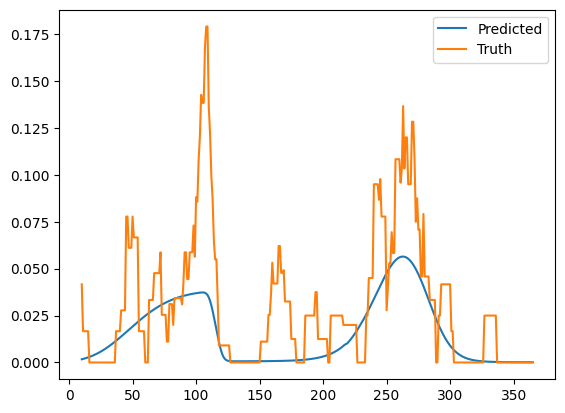

In [33]:
bimig.plot_prediction(p_, data)


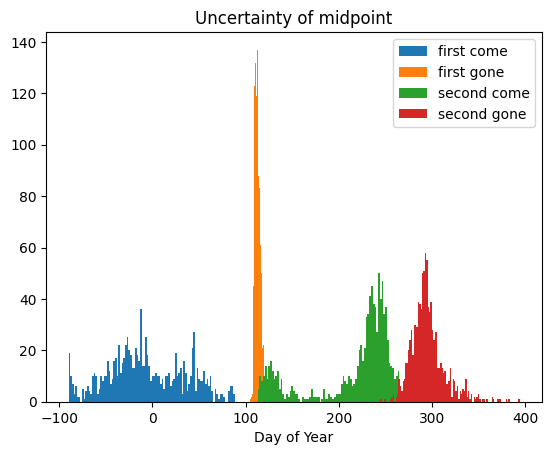

In [38]:
bimig.plot_midpoint(idata)

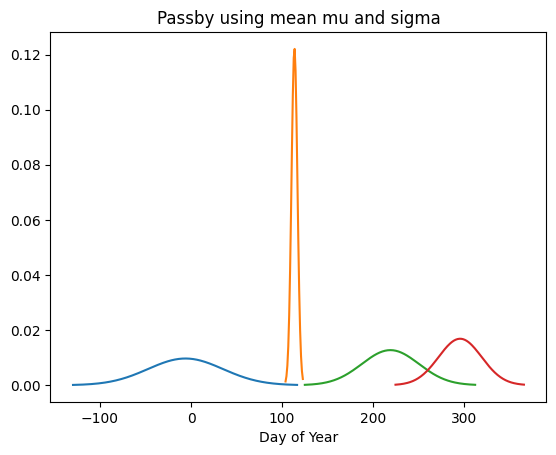

In [50]:
bimig.plot_mean_mid_and_sigma(idata)

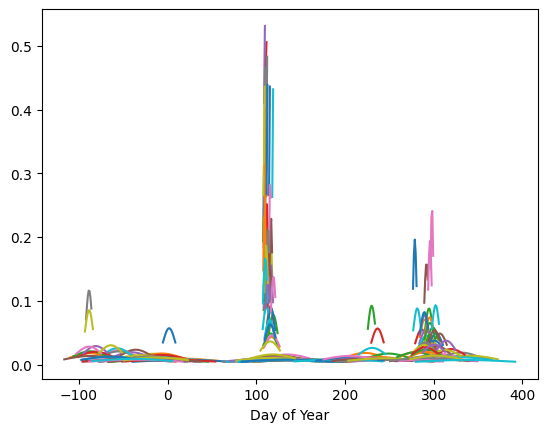

In [51]:
bimig.plot_sample_mid_and_sigma(idata)
